# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#MNIST" data-toc-modified-id="MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MNIST</a></div><div class="lev2 toc-item"><a href="#Deep-Autoencoder" data-toc-modified-id="Deep-Autoencoder-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Deep Autoencoder</a></div><div class="lev2 toc-item"><a href="#Shallow-Autoencoder" data-toc-modified-id="Shallow-Autoencoder-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Shallow Autoencoder</a></div><div class="lev1 toc-item"><a href="#Denoising-Autoencoder" data-toc-modified-id="Denoising-Autoencoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Denoising Autoencoder</a></div><div class="lev1 toc-item"><a href="#Sparse-Autoencoders" data-toc-modified-id="Sparse-Autoencoders-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sparse Autoencoders</a></div>

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

# from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

from rep import preprocessing as p
from rep.linear_regression import Transform

# Utility Functions

In [43]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(30, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [49]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Deep Autoencoder

In [31]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)

In [32]:
def cross(norm_gtex):
    # load invidivudals
    path = os.path.join("..","..","data","processed","gtex","recount")

    train = []
    valid = []
    test = []
    states = ['train','valid','test']
    dict_states_indiv = {'train':train,'valid':valid,'test':test}

    for s in states:
        with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
            for l in f: dict_states_indiv[s].append(l.replace("\n",""))


    selected_genes = norm_gtex.obs_names # training with all features
    print("Total Genes: ",len(selected_genes))

    # compute cross tissue matrix
    (X_train_norm, Y_train_norm, samples_description_train, gene_id_train) = p.rnaseq_cross_tissue(norm_gtex, individuals=train, gene_ids=selected_genes, onlyBlood = True)
    (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid) = p.rnaseq_cross_tissue(norm_gtex, individuals=valid, gene_ids=selected_genes, onlyBlood = True)
    (X_test_norm, Y_test_norm, samples_description_test, gene_id_test) = p.rnaseq_cross_tissue(norm_gtex, individuals=test, gene_ids=selected_genes, onlyBlood = True)
    
    return  (X_train_norm, Y_train_norm, samples_description_train, gene_id_train), (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid), (X_test_norm, Y_test_norm, samples_description_test, gene_id_test)

In [33]:
(X_train, Y_train, _, _), (X_valid, Y_valid, _, _), (X_test, Y_test, _, _) = cross(gtex)

Total Genes:  19932
samples_df  (8911, 14)
samples_df_sliced  (5389, 14)
compute all arrangements
Total pairs: 4403
samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 1630
samples_df  (8911, 14)
samples_df_sliced  (1702, 14)
compute all arrangements
Total pairs: 1558


In [52]:
(x_train,y_train,x_scaler,y_scaler) = Transform(X_train,Y_train).fit_transform()
(x_test, y_test) = Transform(X_valid,Y_valid).transform(x_scaler, y_scaler)
print(x_train.shape)
print(x_test.shape)

(4403, 19932)
(1630, 19932)


In [57]:
input_size = 19932
hidden_size = 1024
hidden_size_2 = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
hidden_2 = Dense(hidden_size_2, activation='relu')(hidden_1)
code = Dense(code_size, activation='relu')(hidden_2)
hidden_3 = Dense(hidden_size_2, activation='relu')(code)
hidden_4 = Dense(hidden_size, activation='relu')(hidden_3)
output_img = Dense(input_size, activation='sigmoid')(hidden_4)

In [58]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.000001, decay=0.0, amsgrad=False)
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')
autoencoder.fit(x_train, x_train, epochs=100)

Epoch 1/100
4403/4403 [==============================] - 154s 35ms/step - loss: 0.9660
Epoch 2/100
4403/4403 [==============================] - 133s 30ms/step - loss: 0.9704
Epoch 3/100
4403/4403 [==============================] - 107s 24ms/step - loss: 0.9711
Epoch 4/100
4403/4403 [==============================] - 109s 25ms/step - loss: 0.9711
Epoch 5/100
4403/4403 [==============================] - 135s 31ms/step - loss: 0.9711
Epoch 6/100
4403/4403 [==============================] - 105s 24ms/step - loss: 0.9711
Epoch 7/100
4403/4403 [==============================] - 108s 24ms/step - loss: 0.9711
Epoch 8/100
4403/4403 [==============================] - 137s 31ms/step - loss: 0.9711
Epoch 9/100
4403/4403 [==============================] - 112s 25ms/step - loss: 0.9711
Epoch 10/100
4403/4403 [==============================] - 104s 24ms/step - loss: 0.9711
Epoch 11/100
4403/4403 [==============================] - 109s 25ms/step - loss: 0.9711
Epoch 12/100
4403/4403 [=================

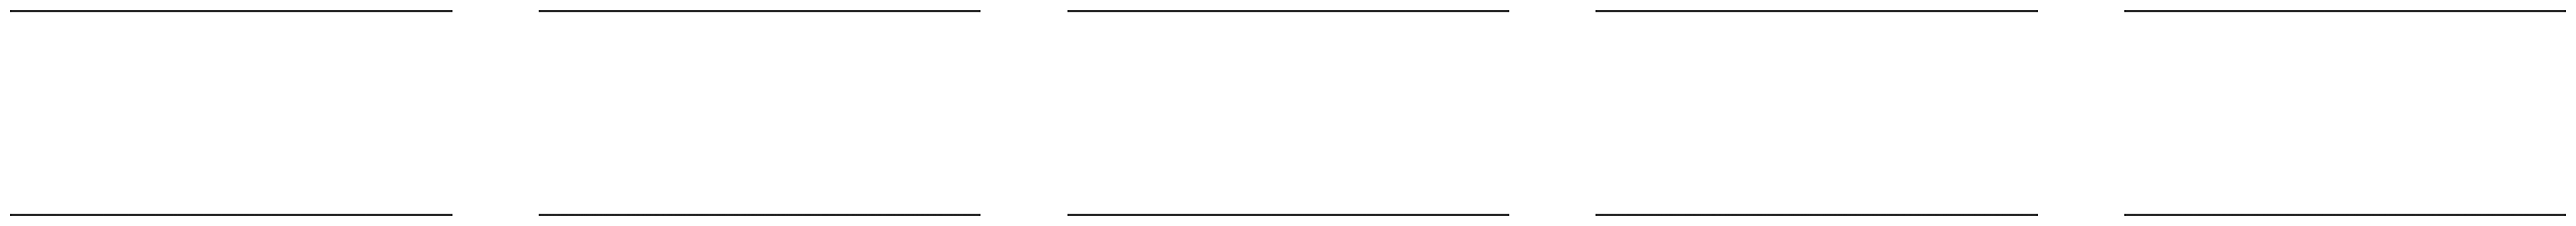

In [45]:
plot_autoencoder_outputs(autoencoder, 5, (4,4983))

In [46]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(4, 4983))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


In [5]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 15s 256us/step - loss: 0.1377
Epoch 2/3
60000/60000 [==============================] - 14s 236us/step - loss: 0.0994
Epoch 3/3
60000/60000 [==============================] - 14s 231us/step - loss: 0.0936


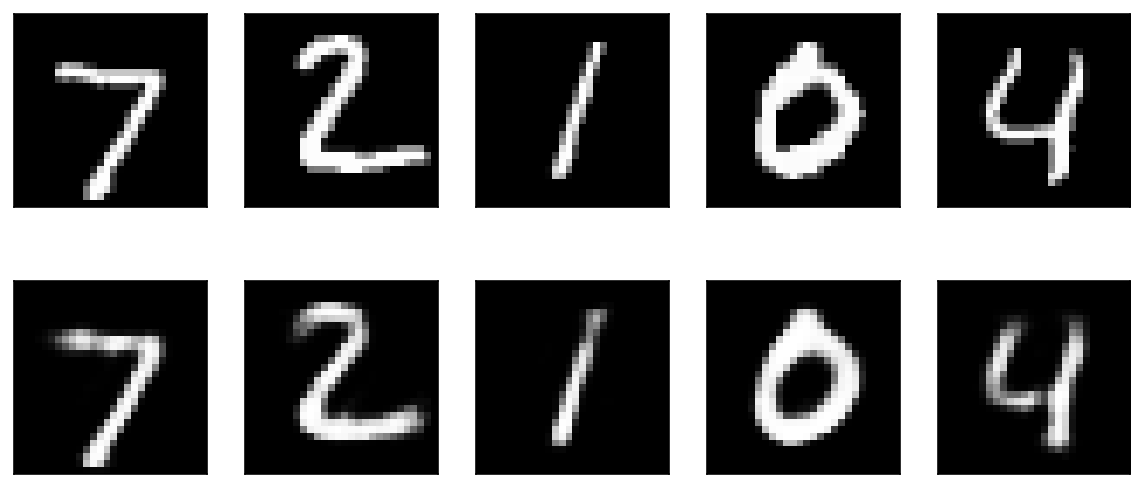

In [6]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

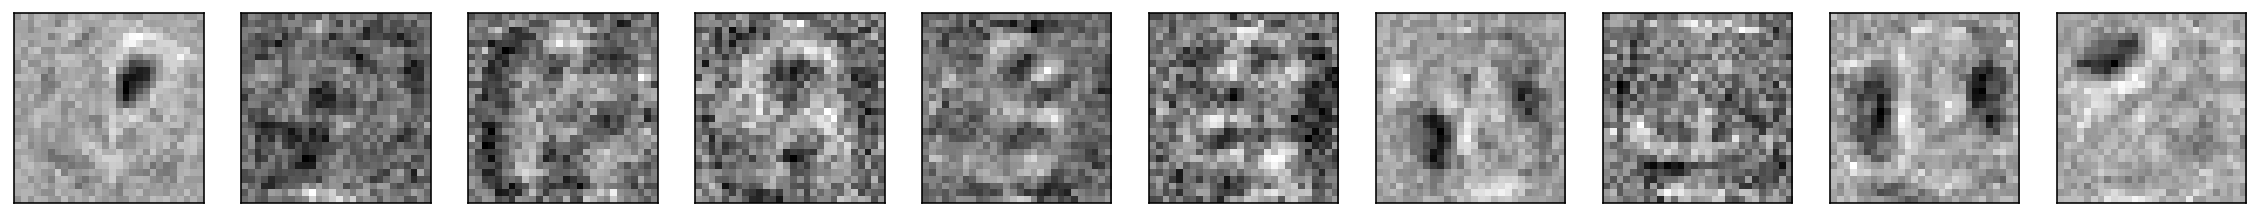

In [7]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

## Shallow Autoencoder

In [8]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 10s 164us/step - loss: 0.1630
Epoch 2/5
60000/60000 [==============================] - 10s 166us/step - loss: 0.1040
Epoch 3/5
60000/60000 [==============================] - 9s 157us/step - loss: 0.0963
Epoch 4/5
60000/60000 [==============================] - 9s 156us/step - loss: 0.0950
Epoch 5/5
60000/60000 [==============================] - 9s 150us/step - loss: 0.0945


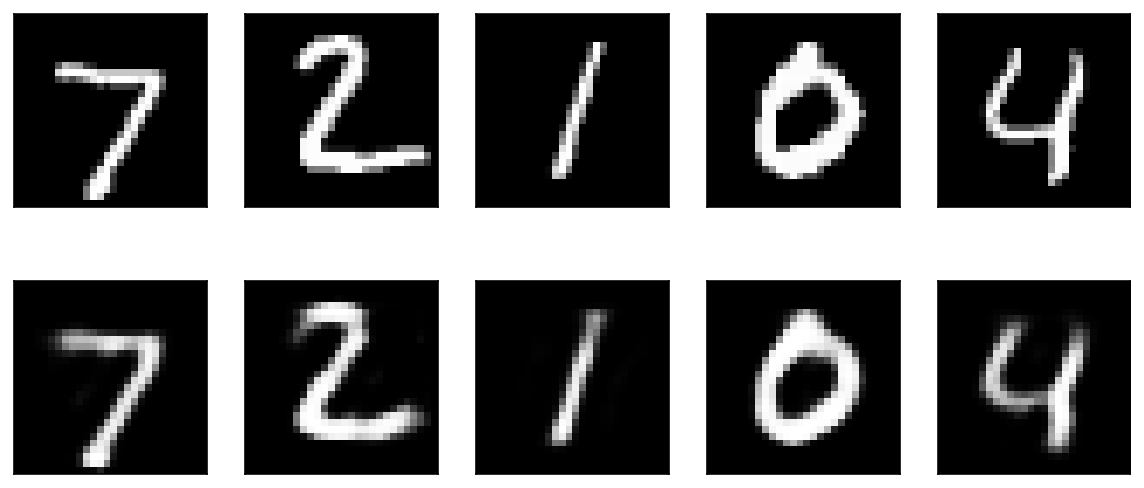

In [9]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

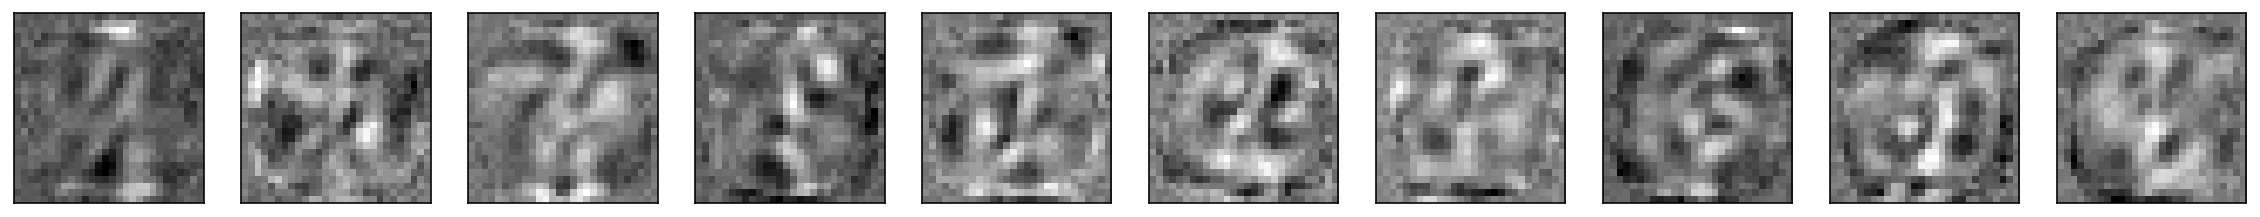

In [10]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Denoising Autoencoder

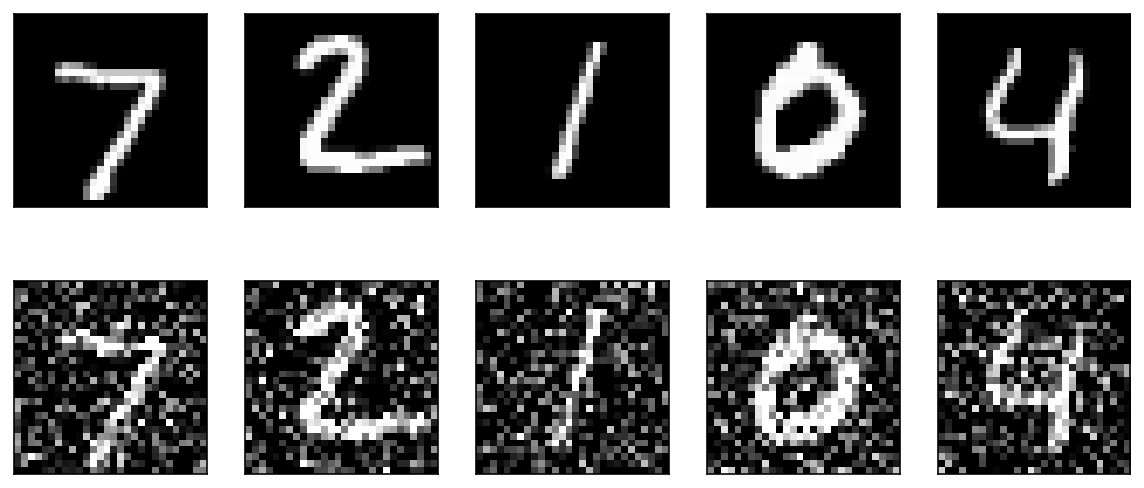

In [11]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [12]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 16s 264us/step - loss: 0.1644
Epoch 2/10
60000/60000 [==============================] - 14s 240us/step - loss: 0.1267
Epoch 3/10
60000/60000 [==============================] - 15s 246us/step - loss: 0.1189
Epoch 4/10
60000/60000 [==============================] - 15s 246us/step - loss: 0.1153
Epoch 5/10
60000/60000 [==============================] - 14s 240us/step - loss: 0.1131
Epoch 6/10
60000/60000 [==============================] - 15s 244us/step - loss: 0.1114
Epoch 7/10
60000/60000 [==============================] - 15s 245us/step - loss: 0.1104
Epoch 8/10
60000/60000 [==============================] - 15s 245us/step - loss: 0.1096
Epoch 9/10
60000/60000 [==============================] - 14s 239us/step - loss: 0.1090
Epoch 10/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.1085


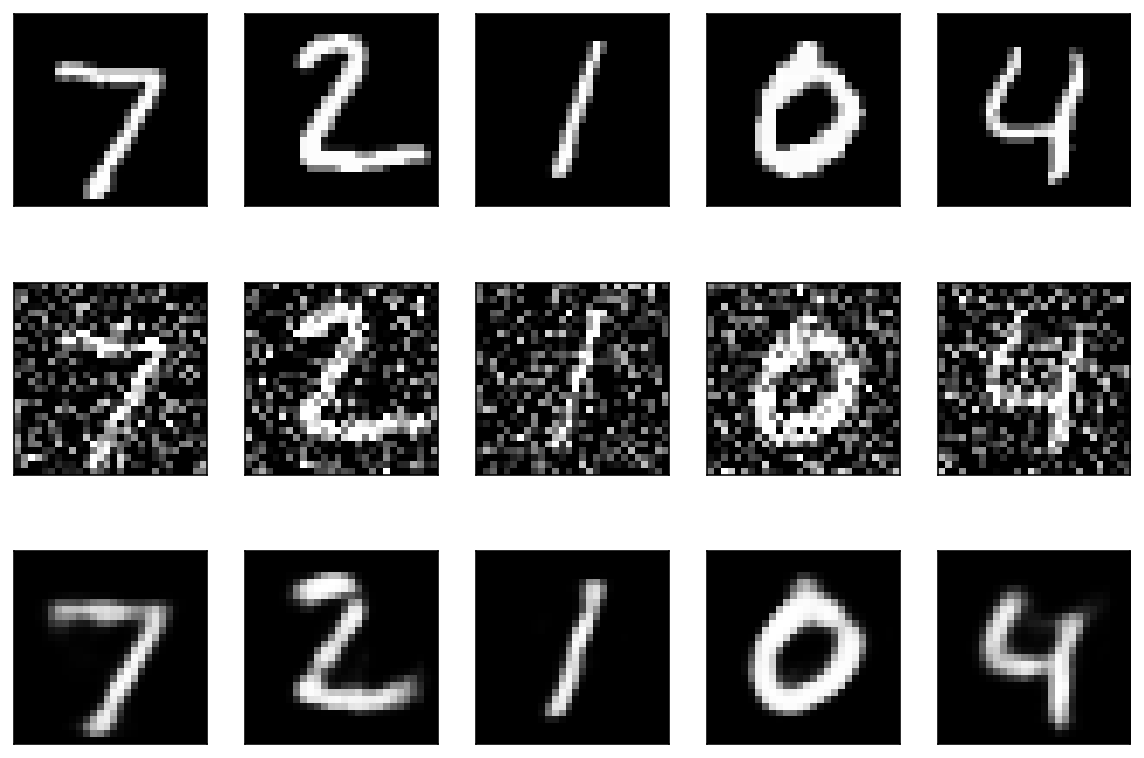

In [13]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

# Sparse Autoencoders

In [14]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 10s 159us/step - loss: 0.1617
Epoch 2/20
60000/60000 [==============================] - 9s 154us/step - loss: 0.1048
Epoch 3/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.0967
Epoch 4/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.0952
Epoch 5/20
60000/60000 [==============================] - 9s 147us/step - loss: 0.0946
Epoch 6/20
60000/60000 [==============================] - 9s 155us/step - loss: 0.0943
Epoch 7/20
60000/60000 [==============================] - 9s 151us/step - loss: 0.0941
Epoch 8/20
60000/60000 [==============================] - 9s 153us/step - loss: 0.0940
Epoch 9/20
60000/60000 [==============================] - 10s 159us/step - loss: 0.0939
Epoch 10/20
60000/60000 [==============================] - 9s 158us/step - loss: 0.0938
Epoch 11/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.0937
Epoch 12/20
60000/60000 [==============

In [15]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 10s 159us/step - loss: 0.1834
Epoch 2/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.1289
Epoch 3/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.1185
Epoch 4/20
60000/60000 [==============================] - 9s 151us/step - loss: 0.1145
Epoch 5/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.1121
Epoch 6/20
60000/60000 [==============================] - 9s 154us/step - loss: 0.1104
Epoch 7/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.1091
Epoch 8/20
60000/60000 [==============================] - 9s 157us/step - loss: 0.1081
Epoch 9/20
60000/60000 [==============================] - 9s 149us/step - loss: 0.1073
Epoch 10/20
60000/60000 [==============================] - 9s 156us/step - loss: 0.1067
Epoch 11/20
60000/60000 [==============================] - 9s 150us/step - loss: 0.1061
Epoch 12/20
60000/60000 [===============

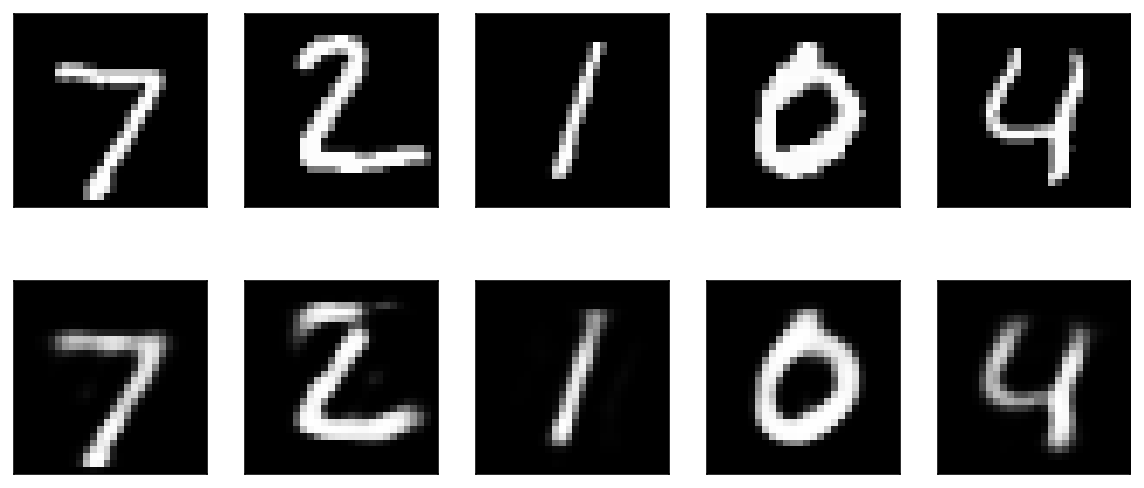

In [16]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

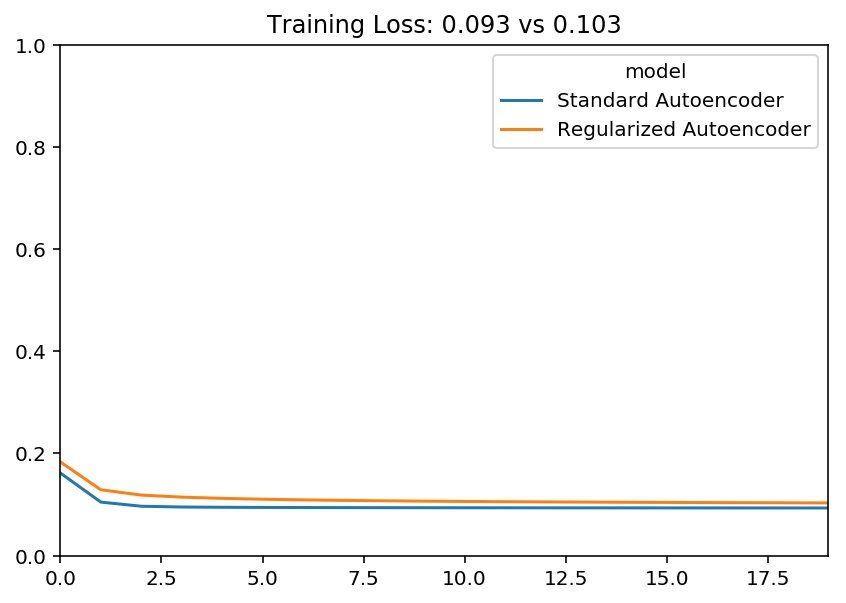

In [17]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [18]:
autoencoder_standard.evaluate(x_test, x_test)

10000/10000 [==============================] - 1s 73us/step


0.0920709709763527

In [19]:
autoencoder_regularized.evaluate(x_test, x_test)

10000/10000 [==============================] - 1s 78us/step


0.10189305981397628

In [20]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

6.800141
0.7712374


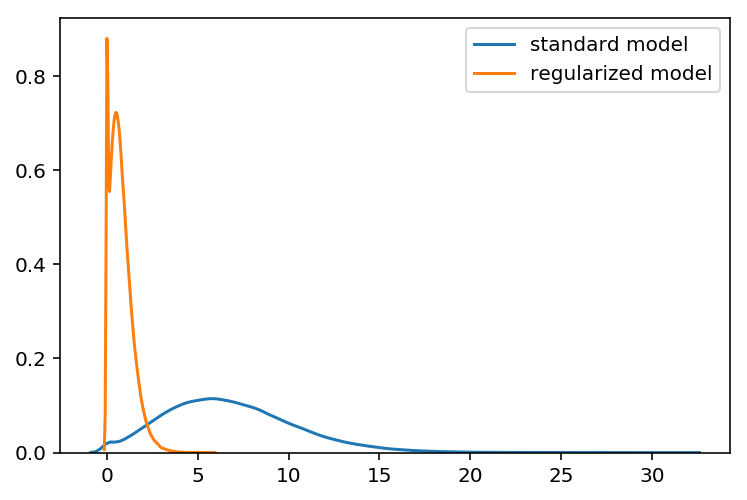

In [21]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')

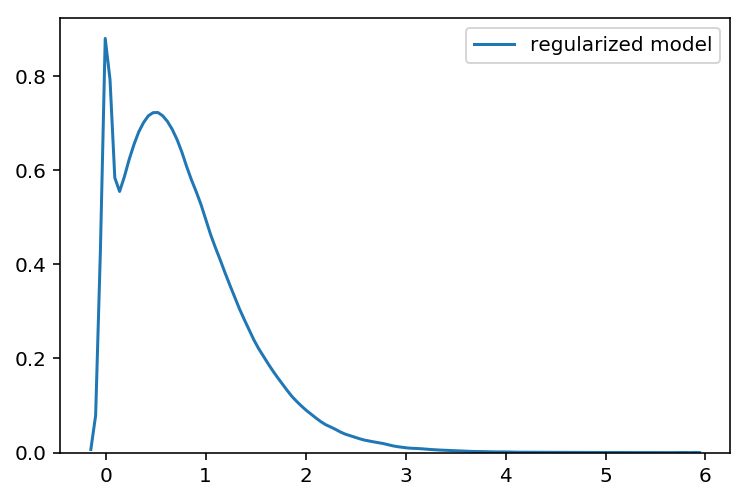

In [22]:
sns.distplot(regularized_scores, hist=False, label='regularized model')